# EXERCISE QUESTIONS
#### Using the data provided, create a series of visualizations (e.g., charts, graphs, etc.) that answer the following questions regarding the results of the 2006 Pike’s Peak 10k Race:

1. What are the mean, median, mode, and range of the race results for all racers by gender?
2. Analyze the difference between gun and net time race results.
3. How much time separates Chris Doe from the top 10 percentile of racers of the same division?
4. Compare the race results of each division.

## Data Dictionary
    Field: Name Description

    Place: The order in which each racer finished relative to racers of the same gender

    Div/Tot: A division comprises racers of the same gender and age group* / The total number of racers within the   same division

    Num: Racer’s bib number
    
    Name: Name of the racer

    Ag: Age of the racer

    Hometown: Hometown of the racer

    Gun Tim: Elapsed time from the formal start of the race and when the racer crossed the finish line

    Net Tim: Elapsed time from when the racer crossed the starting line and when the racer crossed the finish line

    Pace: Racer’s average time per mile during this race
    
    * The two youngest age groups are 0-14 and 15-19; the remaining age groups are separated by 10 year increments (e.g. 20-29, 30-39, etc.) 

In [443]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prettytable import PrettyTable

In [444]:
# read in data
men_data = pd.read_table('male_newfile.csv', delimiter=',', header=0)
female_data = pd.read_table('female_newfile.csv', delimiter=',', header=0)

In [445]:
# inspect the data
print(men_data.head())
print(men_data.info())
print(men_data.Ag.min())
print(men_data.isnull().sum())

   Place Div/Tot  Num                Name    Ag      Hometown   Gun Tim  \
0      1    1/48    9        Joshua Kemei  22.0       Kenya .  00:28:48   
1      2    2/48   35  George Kirwa Misoi  22.0       Kenya .  00:29:11   
2      3    3/48    3          Jacob Frey  24.0     Oakton VA  00:29:38   
3      4    1/96   49      Gurmessa Kumsa  27.0  Oxon Hill MD  00:29:46   
4      5    4/48   31          Mike Baird  24.0    Ardmore PA  00:30:31   

     Net Tim      Pace  
0  00:28:47#  00:04:38  
1  00:29:10#  00:04:42  
2  00:29:37#  00:04:46  
3  00:29:46#  00:04:48  
4   00:30:30  00:04:55  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 9 columns):
Place       1265 non-null int64
Div/Tot     1263 non-null object
Num         1265 non-null int64
Name        1265 non-null object
Ag          1264 non-null float64
Hometown    1265 non-null object
Gun Tim     1265 non-null object
Net Tim     1265 non-null object
Pace        1265 non-null obje

In [446]:
print(female_data.head())
print(female_data.info())
print(female_data.Ag.min())
print(female_data.isnull().sum())

   Place Div/Tot   Num                Name    Ag         Hometown   Gun Tim  \
0      1    1/86    30  Florence Jepkosgei  22.0          Kenya .  00:32:59   
1      2    2/86     8    Eunice Chepkirui  21.0          Kenya .  00:33:14   
2      3   1/247  3200        Elena Orlova  36.0  Gaithersburg MD  00:34:26   
3      4   1/173     2  Susannah Kvasnicka  34.0   Great Falls VA  00:34:43   
4      5   1/142     6         Casey Smith  26.0     Arlington VA  00:35:04   

     Net Tim      Pace  
0  00:32:58#  00:05:19  
1  00:33:13#  00:05:21  
2  00:34:25#  00:05:33  
3  00:34:42#  00:05:35  
4   00:35:02  00:05:39  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1105 entries, 0 to 1104
Data columns (total 9 columns):
Place       1105 non-null int64
Div/Tot     1103 non-null object
Num         1105 non-null int64
Name        1105 non-null object
Ag          1104 non-null float64
Hometown    1105 non-null object
Gun Tim     1105 non-null object
Net Tim     1105 non-null object
Pace  

## Clean the data

In [466]:
# cleaning the data even further that munge.py missed
# create dict containing extra character to be removed from dataframe
cleaning_dict = {
    '\*': '', 
    '\#': '', 
    'Kenya .': 'Kenya',
    ' VA': '',
    ' MD': '', 
    ' PA': '',
    'D ': '', 
    'M ': '', 
    'A ': '', 
    'V ': '', 
    'N ': ''
}

# remove extra characters
cleaned_men_data = men_data.replace(cleaning_dict, regex=True)
cleaned_female_data = female_data.replace(cleaning_dict, regex=True)

# those with age < 1 will be converted to NaN
cleaned_men_data.loc[cleaned_men_data['Ag'] < 1, 'Ag'] = np.NaN
cleaned_female_data.loc[cleaned_female_data['Ag'] < 1, 'Ag'] = np.NaN

# drop nulls
cleaned_men_data = cleaned_men_data.dropna()
cleaned_female_data = cleaned_female_data.dropna()

# fix division number first make Ag a int 64
cleaned_men_data['Ag'] = cleaned_men_data['Ag'].astype(np.int64)
cleaned_female_data['Ag'] = cleaned_female_data['Ag'].astype(np.int64)

def fixDiv(df):
    df.loc[df.Ag <= 14, 'Div'] = 1
    df.loc[df.Ag >= 15, 'Div'] = 2
    df.loc[df.Ag >= 20, 'Div'] = 3
    df.loc[df.Ag >= 30, 'Div'] = 4
    df.loc[df.Ag >= 40, 'Div'] = 5
    df.loc[df.Ag >= 50, 'Div'] = 6
    df.loc[df.Ag >= 60, 'Div'] = 7
    df.loc[df.Ag >= 70, 'Div'] = 8
    df.loc[df.Ag >= 80, 'Div'] = 9
    df.loc[df.Ag >= 90, 'Div'] = 10
    
fixDiv(cleaned_men_data)
fixDiv(cleaned_female_data)


# refomat columns time columns into minutes
def getSeconds(cell):
    h, m, s = cell.split(':')
    return (int(h) * 3600 + int(m) * 60 + int(s)) /60

cleaned_men_data['Gun Tim'] = cleaned_men_data['Gun Tim'].apply(getSeconds)
cleaned_men_data['Net Tim'] = cleaned_men_data['Net Tim'].apply(getSeconds)
cleaned_men_data['Pace'] = cleaned_men_data['Pace'].apply(getSeconds)

cleaned_female_data['Gun Tim'] = cleaned_female_data['Gun Tim'].apply(getSeconds)
cleaned_female_data['Net Tim'] = cleaned_female_data['Net Tim'].apply(getSeconds)
cleaned_female_data['Pace'] = cleaned_female_data['Pace'].apply(getSeconds)

In [448]:
# make sure mens data is clean
print(cleaned_men_data.head())
print(cleaned_men_data.info())
print(cleaned_men_data.isnull().sum())

   Place Div/Tot  Num                Name  Ag   Hometown    Gun Tim  \
0      1    1/48    9        Joshua Kemei  22      Kenya  28.800000   
1      2    2/48   35  George Kirwa Misoi  22      Kenya  29.183333   
2      3    3/48    3          Jacob Frey  24     Oakton  29.633333   
3      4    1/96   49      Gurmessa Kumsa  27  Oxon Hill  29.766667   
4      5    4/48   31          Mike Baird  24    Ardmore  30.516667   

     Net Tim      Pace  Div  
0  28.783333  4.633333  3.0  
1  29.166667  4.700000  3.0  
2  29.616667  4.766667  3.0  
3  29.766667  4.800000  3.0  
4  30.500000  4.916667  3.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261 entries, 0 to 1264
Data columns (total 10 columns):
Place       1261 non-null int64
Div/Tot     1261 non-null object
Num         1261 non-null int64
Name        1261 non-null object
Ag          1261 non-null int64
Hometown    1261 non-null object
Gun Tim     1261 non-null float64
Net Tim     1261 non-null float64
Pace        1261 non-nu

In [449]:
# make sure womens data is clean
print(cleaned_female_data.head())
print(cleaned_female_data.info())
print(cleaned_female_data.isnull().sum())

   Place Div/Tot   Num                Name  Ag      Hometown    Gun Tim  \
0      1    1/86    30  Florence Jepkosgei  22         Kenya  32.983333   
1      2    2/86     8    Eunice Chepkirui  21         Kenya  33.233333   
2      3   1/247  3200        Elena Orlova  36  Gaithersburg  34.433333   
3      4   1/173     2  Susannah Kvasnicka  34   Great Falls  34.716667   
4      5   1/142     6         Casey Smith  26     Arlington  35.066667   

     Net Tim      Pace  Div  
0  32.966667  5.316667  3.0  
1  33.216667  5.350000  3.0  
2  34.416667  5.550000  4.0  
3  34.700000  5.583333  4.0  
4  35.033333  5.650000  3.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 0 to 1104
Data columns (total 10 columns):
Place       1101 non-null int64
Div/Tot     1101 non-null object
Num         1101 non-null int64
Name        1101 non-null object
Ag          1101 non-null int64
Hometown    1101 non-null object
Gun Tim     1101 non-null float64
Net Tim     1101 non-null float64

## 1. What are the mean, median, mode, and range of the race results for all racers by gender?

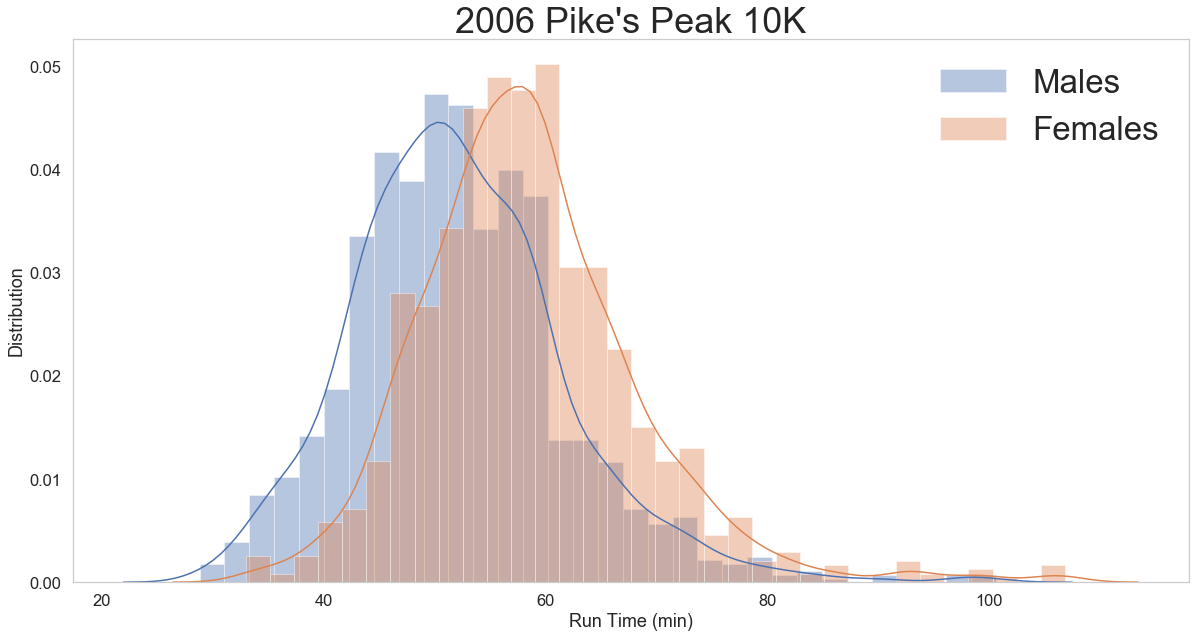

In [450]:
# Calculate stats
men_avg = round(np.mean(cleaned_men_data['Net Tim']), 2)
men_median = round(np.median(cleaned_men_data['Net Tim']), 2)
men_mode = int(stats.mode(cleaned_men_data['Net Tim'])[0])
men_range = round(max(cleaned_men_data['Net Tim']) - min(cleaned_men_data['Net Tim']), 2)

women_avg = round(np.mean(cleaned_female_data['Net Tim']), 2)
women_median = round(np.median(cleaned_female_data['Net Tim']), 2)
women_mode = int(stats.mode(cleaned_female_data['Net Tim'])[0])
women_range = round(max(cleaned_female_data['Net Tim']) - min(cleaned_female_data['Net Tim']), 2)

# graphs men and women's distributed net time together
%matplotlib inline
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.set(font_scale=3)
ax = sns.distplot(cleaned_men_data['Net Tim'], label='Males', )
ax = sns.distplot(cleaned_female_data['Net Tim'], label='Females')
ax.set(xlabel='Run Time (min)', ylabel='Distribution', title="2006 Pike's Peak 10K")
ax.grid(False)

plt.legend()

plt.show()

In [451]:
# Format stats into a nice table
stats_table = PrettyTable()

stats_table.field_names = ['Gender', 'Mean', 'Median', 'Mode', 'Range']

stats_table.add_row(["Males", men_avg, men_median, men_mode, men_range])
stats_table.add_row(["Females", women_avg, women_median, women_mode, women_range])
stats_table.title = "2006 Pike's Peak 10K Race"

print(stats_table)

+-----------------------------------------+
|        2006 Pike's Peak 10K Race        |
+---------+-------+--------+------+-------+
|  Gender |  Mean | Median | Mode | Range |
+---------+-------+--------+------+-------+
|  Males  | 52.12 | 51.37  |  35  | 71.85 |
| Females | 58.45 | 57.82  |  48  | 73.85 |
+---------+-------+--------+------+-------+


### The men's stats are generally lower than that of the women's. Placing them at slightly faster overall.

## 2. Analyze the difference between gun and net time race results.

In [453]:
# Aggregate the Gun and net time for comparison
cleaned_men_data['Tim Diff'] = cleaned_men_data['Gun Tim'] - cleaned_men_data['Net Tim']
cleaned_female_data['Tim Diff'] = cleaned_female_data['Gun Tim'] - cleaned_female_data['Net Tim']

In [454]:
# create a new dataframe to more easily graph the data
agg_data = [['females', 'Difference Gun and Net',np.mean(cleaned_female_data['Tim Diff'])], ['females', 'Average Pace', np.mean(cleaned_female_data['Pace'])], ['males', 'Difference Gun and Net', np.mean(cleaned_men_data['Tim Diff'])], ['males', 'Average Pace', np.mean(cleaned_men_data['Pace'])]]
agg_data_df = pd.DataFrame(agg_data, columns=['Gender', 'Legend', 'Time (minutes)'])

<Figure size 1440x720 with 0 Axes>

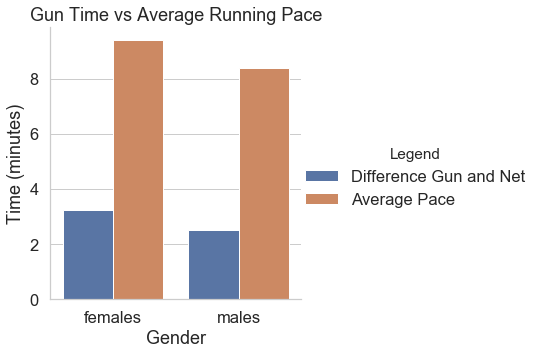

In [455]:
# plot the aggregated dataframe
%matplotlib inline
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.catplot(x='Gender', y='Time (minutes)', hue="Legend", data=agg_data_df, kind='bar')
plt.title('Gun Time vs Average Running Pace')
plt.show()

### The difference between the gun and net running times seems to have the same trend as the pace. Which makes sense because a slower pace will take longer to get across the start line.

In [457]:
# aggregate the data we want to compare
men_net_avg = round(np.mean(cleaned_men_data['Net Tim']), 2)
men_gun_avg = round(np.mean(cleaned_men_data['Gun Tim']), 2)
men_pace_avg = round(np.mean(cleaned_men_data['Pace']), 2)

women_net_avg = round(np.mean(cleaned_female_data['Net Tim']), 2)
women_gun_avg = round(np.mean(cleaned_female_data['Gun Tim']), 2)
women_pace_avg = round(np.mean(cleaned_female_data['Pace']), 2)

In [458]:
# create a new dataframe to more easily graph the data
agg2_data = [['males', 'Net Time Avg', men_net_avg], ['males', 'Gun Time Avg', men_gun_avg], ['females', 'Net Time Avg', women_net_avg], ['females', 'Gun Time Avg', women_gun_avg]]
agg2_data_df = pd.DataFrame(agg2_data, columns=('Gender', 'Legend', 'Time (minutes)'))

<Figure size 1440x720 with 0 Axes>

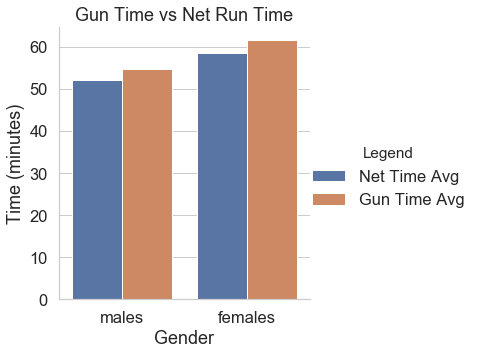

In [459]:
# plot the aggregated dataframe
%matplotlib inline
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.catplot(x='Gender', y='Time (minutes)', hue="Legend", data=agg2_data_df, kind='bar')
plt.title('Gun Time vs Net Run Time')
plt.show()

### The gun and net running times are close. Women, who tend to be slower, have a proportional difference between their gun and net time.

## 3. How much time separates Chris Doe from the top 10 percentile of racers of the same division?

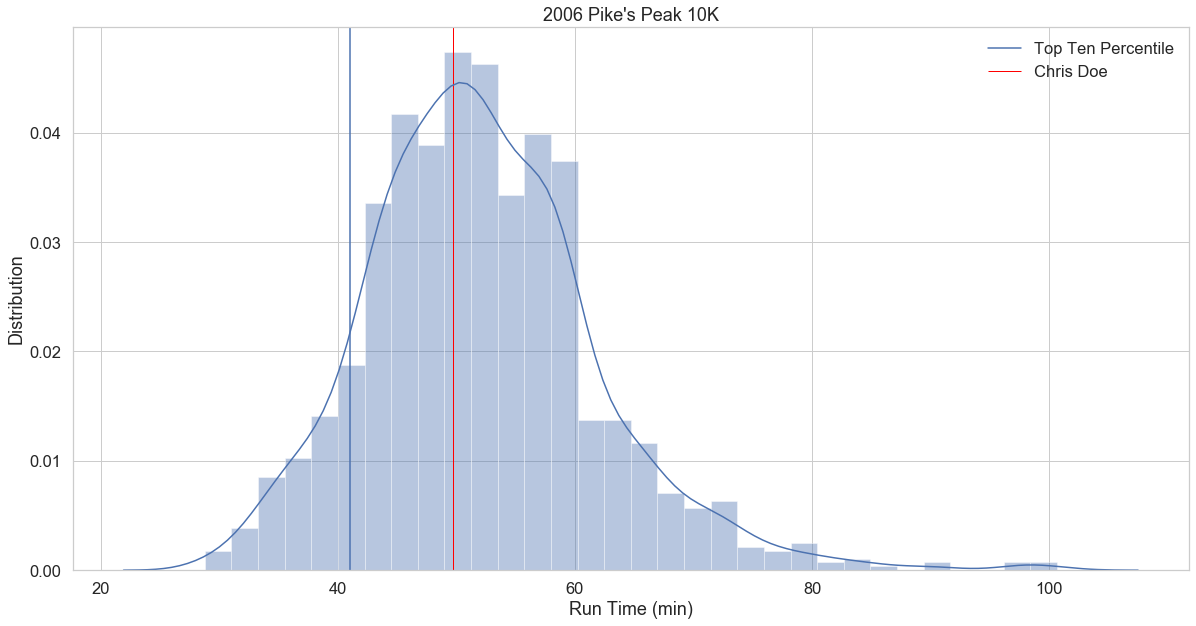

In [461]:
# plot the running time distribution for the men
# put a line where the top ten percentile is and one for chris

# find chris's running time
chris_doe =round(cleaned_men_data.loc[cleaned_men_data['Name'] == 'Chris Doe', 'Net Tim'], 2)

# find the top 10 percentile
top_ten = np.percentile(cleaned_men_data['Net Tim'], 10)

%matplotlib inline
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.distplot(cleaned_men_data['Net Tim'])
sns.rugplot(chris_doe, color='red', height=1, label = 'Chris Doe')
plt.axvline(top_ten, label='Top Ten Percentile')

ax.set(xlabel='Run Time (min)', ylabel='Distribution', title="2006 Pike's Peak 10K")

plt.legend()

plt.show()

In [462]:
print("Chris Doe's Run Time:", float(chris_doe),"minutes")
print("Top Ten Percentile Time:", round(top_ten, 2), 'minutes')

chris_diff = round(float(chris_doe)-top_ten, 2)

print("Chris Doe is", chris_diff, "minutes slower than the top ten percentile. That puts him with the majority of the other runners.")

Chris Doe's Run Time: 49.72 minutes
Top Ten Percentile Time: 41.0 minutes
Chris Doe is 8.72 minutes slower than the top ten percentile. That puts him with the majority of the other runners.


### Chris Doe's Run Time: 49.72 minutes
### Top Ten Percentile Time: 41.0 minutes
### Chris Doe is 8.72 minutes slower than the top ten percentile. That puts him with the majority of the other runners.

## 4. Compare the race results of each division.

In [463]:
# sort data by division to make handling easier later first by converting it to a numeric so it sorts properly
cleaned_men_data['Div'] = pd.to_numeric(cleaned_men_data['Div'], errors='coerce')
cleaned_men_data = cleaned_men_data.sort_values('Div')

cleaned_female_data['Div'] = pd.to_numeric(cleaned_female_data['Div'], errors='coerce')
cleaned_female_data = cleaned_female_data.sort_values('Div')

In [464]:
# create new dataframe grouped by division and aggregating age, net tim, and pace by the mean
div_men = cleaned_men_data.groupby('Div').agg({'Ag': 'mean', 'Net Tim': 'mean', 'Pace': 'mean'})
div_men = div_men.reset_index()

# inspect the new dataframes
print(div_men.head())
print(div_men.info())

div_women = cleaned_female_data.groupby('Div').agg({'Ag': 'mean', 'Net Tim': 'mean', 'Pace': 'mean'})
div_women = div_women.reset_index()
print(div_women.head())
print(div_women.info())

   Div         Ag    Net Tim      Pace
0  1.0  12.692308  55.039103  8.862821
1  2.0  16.533333  46.654444  7.515185
2  3.0  25.597222  49.522454  7.976505
3  4.0  34.942197  51.655202  8.319798
4  5.0  44.368675  51.605020  8.311526
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
Div        9 non-null float64
Ag         9 non-null float64
Net Tim    9 non-null float64
Pace       9 non-null float64
dtypes: float64(4)
memory usage: 416.0 bytes
None
   Div         Ag    Net Tim      Pace
0  1.0  11.769231  58.982051  9.498718
1  2.0  17.038462  52.130769  8.397436
2  3.0  25.486842  57.246272  9.219810
3  4.0  34.938095  58.702778  9.453889
4  5.0  43.833922  57.870082  9.319965
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
Div        8 non-null float64
Ag         8 non-null float64
Net Tim    8 non-null float64
Pace       8 non-null float64
dtypes: float64(4)
memory usage: 384.0 byt

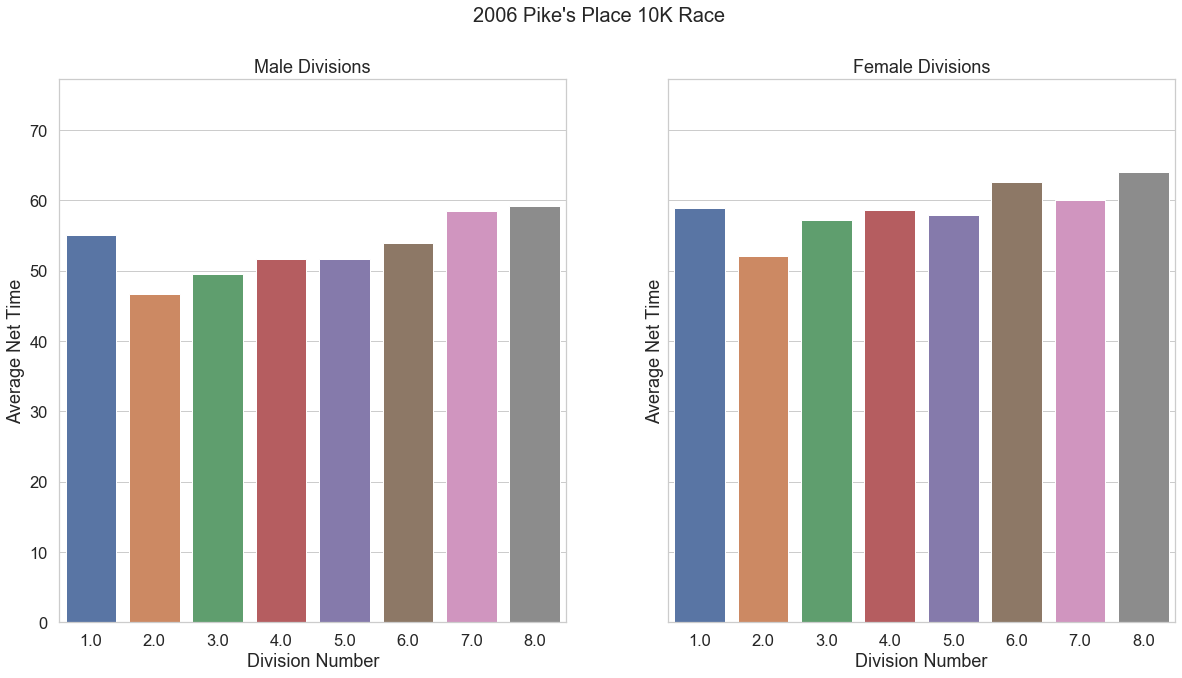

In [465]:
# plot the net running time for each division
fig, ax= plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
sns.barplot(x="Div", y="Net Tim", data=div_men, ax=ax[0])
sns.barplot(x="Div", y="Net Tim", data=div_women, ax=ax[1])

plt.suptitle("2006 Pike's Place 10K Race", size=20)
ax[0].set_title("Male Divisions")
ax[1].set_title("Female Divisions")

ax[0].set_xlabel("Division Number")
ax[1].set_xlabel("Division Number")
ax[0].set_ylabel("Average Net Time")
ax[1].set_ylabel("Average Net Time")

plt.show()

### The data from the divisions show an interesting trend. The second division (kids 15 to 19) are the fastest groups and as people age they tend to be slower. Overall, males tend to be faster than females but both genders show a similar trend.